In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns

import librosa as lb
import librosa.display as lbd
import os


In [ ]:
train=pd.read_csv('../input/part-2-handel-imbalance-creating-spectrogram/train.csv')
val=pd.read_csv('../input/part-2-handel-imbalance-creating-spectrogram/val.csv')
train.head()

,Unnamed: 0,pid,filename,disease
0,1481,176,176_1b3_Ll_mc_AKGC417L_3.wav,COPD
1,6197,144,144_1b1_Al_sc_Meditron_9.wav,Healthy
2,499,193,193_1b2_Ll_mc_AKGC417L_0.wav,COPD
3,6559,208,208_1b1_Ll_sc_Meditron_8.wav,Healthy
4,1238,154,154_3b3_Al_mc_AKGC417L_3.wav,COPD


In [ ]:
ytrain=train.disease
yval=val.disease
yval

0       COPD
1       COPD
2       COPD
3       COPD
4       COPD
        ... 
1720    COPD
1721    COPD
1722    COPD
1723    COPD
1724    COPD
Name: disease, Length: 1725, dtype: object

* As our class labels are of **dtype: object** we must first convert them to **encoded values** or intergers

In [ ]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
ytrain=le.fit_transform(ytrain)
yval=le.transform(yval)

# Feature Extraction

> I am going to use Librosa's feature extraction methods here

> Note:- i first tried to extract features **1-by-1** and then test them, to see how they perform but most of then were giving **good accuracy** so i finally decided to use all of them



In [ ]:
def getFeatures(path):
    soundArr,sample_rate=lb.load(path)
    mfcc=lb.feature.mfcc(y=soundArr,sr=sample_rate)
    cstft=lb.feature.chroma_stft(y=soundArr,sr=sample_rate)
    mSpec=lb.feature.melspectrogram(y=soundArr,sr=sample_rate)

    return mfcc,cstft,mSpec

> In These functions i m iterating over **train and val dataset**, and using **filenames** to extract features and then converting them to **numpy arrays**


In [ ]:
root='../input/part-1-preprocessing/processed_audio_files/'
mfcc,cstft,mSpec=[],[],[]

for idx,row in val.iterrows():
    path=root + row['filename']
    a,b,c=getFeatures(path)
    mfcc.append(a)
    cstft.append(b)
    mSpec.append(c)

mfcc_val=np.array(mfcc)
cstft_val=np.array(cstft)
mSpec_val=np.array(mSpec)

/opt/conda/lib/python3.7/site-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


The shape of features returned by the above function **(20, 259) (12, 259) (128, 259)** we need this for defining **input shape** of our model.

In [ ]:
root='../input/part-1-preprocessing/processed_audio_files/'
mfcc,cstft,mSpec=[],[],[]

for idx,row in train.iterrows():
    path=root + row['filename']
    a,b,c=getFeatures(path)
    mfcc.append(a)
    cstft.append(b)
    mSpec.append(c)
#     tone.append(d)
#     specCen.append(e)

mfcc_train=np.array(mfcc)
cstft_train=np.array(cstft)
mSpec_train=np.array(mSpec)

# Testing Features

> Lets create model using Keras **Functional API** to check how the features perform.



In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=0.00001,mode='min')
]

* Here i m creating **three** different **CNN** and then Combining them to a **Dense Network**.

In [ ]:
mfcc_input=keras.layers.Input(shape=(20,259,1),name="mfccInput")
x=keras.layers.Conv2D(32,5,strides=(1,3),padding='same')(mfcc_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(1,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(96,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
mfcc_output=keras.layers.GlobalMaxPooling2D()(x)

mfcc_model=keras.Model(mfcc_input, mfcc_output, name="mfccModel")

In [ ]:
mfcc_model.summary()

Model: "mfccModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mfccInput (InputLayer)       [(None, 20, 259, 1)]      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 20, 87, 32)        832       
_________________________________________________________________
batch_normalization_11 (Batc (None, 20, 87, 32)        128       
_________________________________________________________________
activation_11 (Activation)   (None, 20, 87, 32)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 10, 43, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 10, 22, 64)        18496     
_________________________________________________________________
batch_normalization_12 (Batc (None, 10, 22, 64)        25

In [ ]:
croma_input=keras.layers.Input(shape=(12,259,1),name="cromaInput")
x=keras.layers.Conv2D(32,5,strides=(1,3),padding='same')(croma_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(1,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
croma_output=keras.layers.GlobalMaxPooling2D()(x)

croma_model=keras.Model(croma_input, croma_output, name="cromaModel")

In [ ]:
croma_model.summary()

Model: "cromaModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cromaInput (InputLayer)      [(None, 12, 259, 1)]      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 12, 87, 32)        832       
_________________________________________________________________
batch_normalization_15 (Batc (None, 12, 87, 32)        128       
_________________________________________________________________
activation_15 (Activation)   (None, 12, 87, 32)        0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 6, 43, 32)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 6, 22, 64)         18496     
_________________________________________________________________
batch_normalization_16 (Batc (None, 6, 22, 64)         2

In [ ]:
mSpec_input=keras.layers.Input(shape=(128,259,1),name="mSpecInput")
x=keras.layers.Conv2D(32,5,strides=(2,3),padding='same')(mSpec_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(2,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(96,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
mSpec_output=keras.layers.GlobalMaxPooling2D()(x)

mSpec_model=keras.Model(mSpec_input, mSpec_output, name="mSpecModel")

In [ ]:
mSpec_model.summary()

Model: "mSpecModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mSpecInput (InputLayer)      [(None, 128, 259, 1)]     0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 64, 87, 32)        832       
_________________________________________________________________
batch_normalization_18 (Batc (None, 64, 87, 32)        128       
_________________________________________________________________
activation_18 (Activation)   (None, 64, 87, 32)        0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 32, 43, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 16, 22, 64)        18496     
_________________________________________________________________
batch_normalization_19 (Batc (None, 16, 22, 64)        2

In [ ]:
input_mfcc=keras.layers.Input(shape=(20,259,1),name="mfcc")
mfcc=mfcc_model(input_mfcc)

input_croma=keras.layers.Input(shape=(12,259,1),name="croma")
croma=croma_model(input_croma)

input_mSpec=keras.layers.Input(shape=(128,259,1),name="mspec")
mSpec=mSpec_model(input_mSpec)


concat=keras.layers.concatenate([mfcc,croma,mSpec])
hidden=keras.layers.Dropout(0.2)(concat)
hidden=keras.layers.Dense(50,activation='relu')(concat)
hidden=keras.layers.Dropout(0.3)(hidden)
hidden=keras.layers.Dense(25,activation='relu')(hidden)
hidden=keras.layers.Dropout(0.3)(hidden)
output=keras.layers.Dense(8,activation='softmax')(hidden)

net=keras.Model([input_mfcc,input_croma,input_mSpec], output, name="Net")

In [ ]:
net.summary()

Model: "Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mfcc (InputLayer)               [(None, 20, 259, 1)] 0                                            
__________________________________________________________________________________________________
croma (InputLayer)              [(None, 12, 259, 1)] 0                                            
__________________________________________________________________________________________________
mspec (InputLayer)              [(None, 128, 259, 1) 0                                            
__________________________________________________________________________________________________
mfccModel (Functional)          (None, 128)          94560       mfcc[0][0]                       
________________________________________________________________________________________________

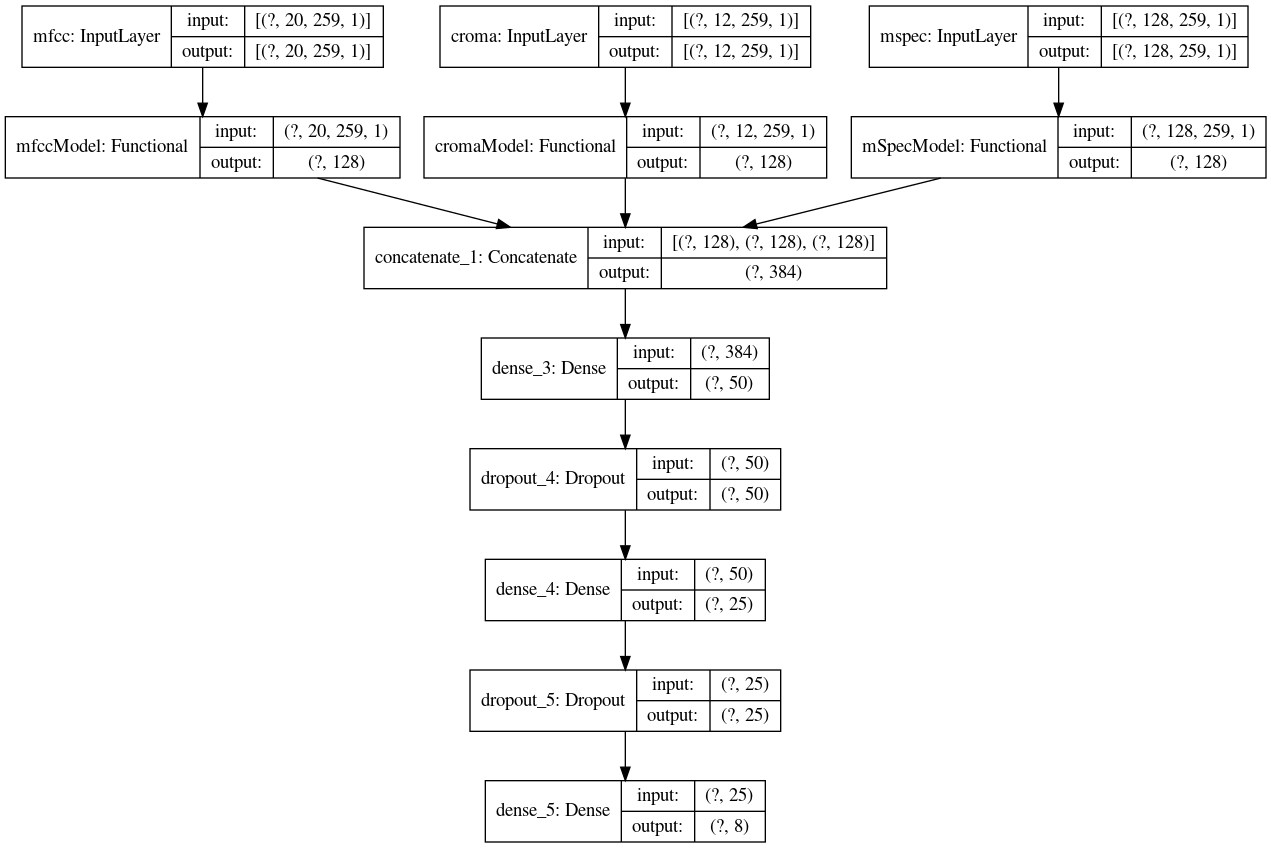

In [ ]:
keras.utils.plot_model(net, "net.png", show_shapes=True)

In [ ]:
from keras import backend as K
net.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
K.set_value(net.optimizer.learning_rate, 0.001)

In [ ]:
history=net.fit(
    {"mfcc":mfcc_train,"croma":cstft_train,"mspec":mSpec_train},
    ytrain,
    validation_data=({"mfcc":mfcc_val,"croma":cstft_val,"mspec":mSpec_val},yval),
    epochs=100,verbose=0,
    callbacks=my_callbacks
)

In [ ]:
import pickle
with open('model.pkl', 'wb') as file:
    pickle.dump(history.history, file)

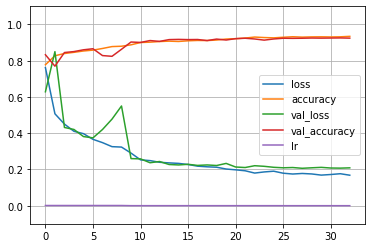

In [ ]:
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.gca().set_ylim(-0.1,1.1)
plt.show()

In [ ]:
net.evaluate({"mfcc":mfcc_val,"croma":cstft_val,"mspec":mSpec_val},yval)

54/54 [==============================] - 0s 5ms/step - loss: 0.2088 - accuracy: 0.9246


[0.2087860256433487, 0.9246376752853394]